In [27]:
# Reading data

import pandas as pd

train=pd.read_csv("C:/Users/HP/Documents/ML103_Kaggle/Data/train.csv")
test=pd.read_csv("C:/Users/HP/Documents/ML103_Kaggle/Data/test.csv")


In [28]:
# Label Encoding
#   Very First I am merging both Test data and Train data then I am encoding them so that we can run most 
#   of the algorithms on the data. In the end I will divide the data into 4 parts i.e. X_train, Y_train, X_test, Y_test.

# 1. Mergind Train and Test Dataset
temp=pd.concat([train,test])

# 2. Lable Encoding
from sklearn import preprocessing

LableEn = preprocessing.LabelEncoder()
temp.workclass         = LableEn.fit_transform(temp.workclass)
temp.education         = LableEn.fit_transform(temp.education)
temp.marital_status    = LableEn.fit_transform(temp.marital_status)
temp.occupation        = LableEn.fit_transform(temp.occupation)
temp.relationship      = LableEn.fit_transform(temp.relationship)
temp.race              = LableEn.fit_transform(temp.race)
temp.sex               = LableEn.fit_transform(temp.sex)
temp.native_country    = LableEn.fit_transform(temp.native_country)
temp.income=temp.income.fillna('NA')
temp.income    = LableEn.fit_transform(temp.income)




In [29]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#train = pd.read_csv('train_modified.csv')
train =temp[['Id','age','workclass','fnlwgt','education','education_num','marital_status',
              'occupation','relationship','race','sex','capital_gain','capital_loss','hr_per_week','native_country','income']][(temp.income==1)|(temp.income==0)]
test=temp[['Id','age','workclass','fnlwgt','education','education_num','marital_status',
              'occupation','relationship','race','sex','capital_gain','capital_loss','hr_per_week','native_country','income']][(temp.income==2)]


target = 'income'
IDcol = 'Id'


In [31]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['income'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['income'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['income'], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8913
AUC Score (Train): 0.948048


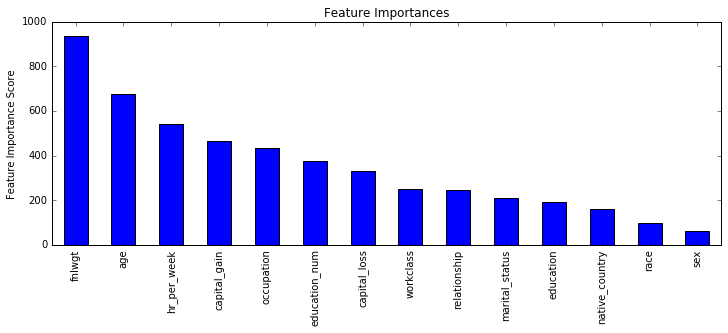

In [38]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


modelfit(xgb1, train, predictors)

In [35]:
#Parameter Tuning
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                                                  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.92287, std: 0.00303, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.92270, std: 0.00315, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.92248, std: 0.00273, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.92739, std: 0.00226, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.92675, std: 0.00221, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.92630, std: 0.00186, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.92723, std: 0.00214, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.92693, std: 0.00239, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.92640, std: 0.00206, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.92503, std: 0.00165, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.92519, std: 0.00216, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.92491, std: 0.00221, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [36]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[0,1,2]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.92609, std: 0.00240, params: {'max_depth': 4, 'min_child_weight': 0},
  mean: 0.92614, std: 0.00254, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.92592, std: 0.00237, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.92745, std: 0.00179, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.92739, std: 0.00226, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.92707, std: 0.00199, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.92729, std: 0.00214, params: {'max_depth': 6, 'min_child_weight': 0},
  mean: 0.92744, std: 0.00209, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.92730, std: 0.00232, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 0},
 0.92744881685984593)

In [39]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.92745, std: 0.00179, params: {'gamma': 0.0},
  mean: 0.92740, std: 0.00164, params: {'gamma': 0.1},
  mean: 0.92723, std: 0.00194, params: {'gamma': 0.2},
  mean: 0.92709, std: 0.00201, params: {'gamma': 0.3},
  mean: 0.92729, std: 0.00200, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.92744881685984593)


Model Report
Accuracy : 0.8932
AUC Score (Train): 0.950811


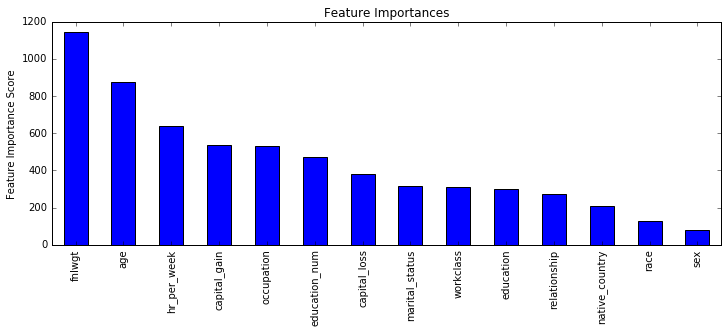

In [40]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=0,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [50]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.92714, std: 0.00198, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.92750, std: 0.00195, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.92772, std: 0.00200, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.92819, std: 0.00199, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.92687, std: 0.00207, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.92752, std: 0.00165, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.92803, std: 0.00232, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.92802, std: 0.00233, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.92649, std: 0.00190, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.92718, std: 0.00170, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.92757, std: 0.00189, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.92784, std: 0.00212, params: {'colsample_bytree': 0.8, 'subsample'

In [47]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=0, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.92819, std: 0.00199, params: {'reg_alpha': 1e-05},
  mean: 0.92817, std: 0.00219, params: {'reg_alpha': 0.01},
  mean: 0.92799, std: 0.00219, params: {'reg_alpha': 0.1},
  mean: 0.92801, std: 0.00221, params: {'reg_alpha': 1},
  mean: 0.91365, std: 0.00325, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.92818809854959528)

In [46]:
param_test6 = {
 'reg_alpha':[5e-7, 1e-6, 5e-6, 1e-5,5e-4]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=0, gamma=0.1, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.92825, std: 0.00221, params: {'reg_alpha': 5e-07},
  mean: 0.92825, std: 0.00221, params: {'reg_alpha': 1e-06},
  mean: 0.92825, std: 0.00221, params: {'reg_alpha': 5e-06},
  mean: 0.92825, std: 0.00221, params: {'reg_alpha': 1e-05},
  mean: 0.92826, std: 0.00222, params: {'reg_alpha': 0.0005}],
 {'reg_alpha': 0.0005},
 0.92825806376863829)


Model Report
Accuracy : 0.8909
AUC Score (Train): 0.947565


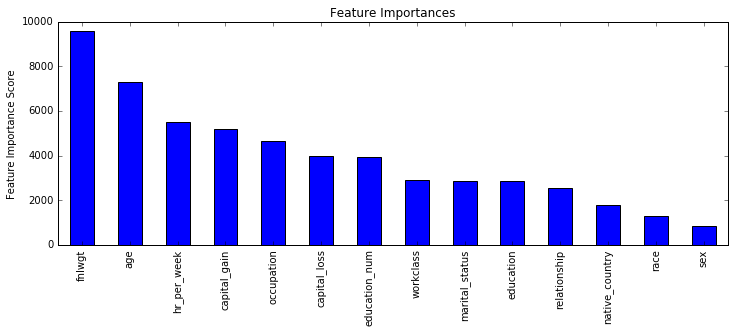

In [49]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=0,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0.0005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [50]:
######################## Making predictions
alg=xgb4
dtrain=train
useTrainCV=True
cv_folds=5
early_stopping_rounds=50
    
if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
alg.fit(dtrain[predictors], dtrain['income'],eval_metric='auc')
    
#Predict training set:
dtrain_predictions = alg.predict(test[predictors])
dtrain_predprob = alg.predict_proba(test[predictors])[:,1]

output=pd.DataFrame(data={'Id':test['Id'],'Prediction':dtrain_predprob})
output.to_csv("submission_xgb_final.csv",index=False)
print("Done")


Done
